In [46]:
import sqlite3;
import pandas as pd;
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [47]:
connection = sqlite3.connect(':memory:')
cursor = connection.cursor()

In [48]:
cursor.execute('''
    CREATE TABLE IF NOT EXISTS departamentos(
        id INTEGER PRIMARY KEY,
        nombre TEXT
    );
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS empleados(
        id INTEGER PRIMARY KEY,
        nombre TEXT,
        edad INTEGER,
        genero TEXT,
        departamento_id INTEGER,
        CONSTRAINT fk_departamento_id FOREIGN KEY(departamento_id) REFERENCES departamentos(id)
    );
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS salarios(
        id INTEGER PRIMARY KEY,
        salario REAL,
        empleado_id INTEGER,
        CONSTRAINT fk_empleado_id FOREIGN KEY(empleado_id) REFERENCES empleados(id)
    );
''')

cursor.execute('''
    CREATE TABLE IF NOT EXISTS evaluaciones(
        id INTEGER PRIMARY KEY,
        evaluacion INTEGER,
        empleado_id INTEGER,
        CONSTRAINT fk_empleado_id FOREIGN KEY(empleado_id) REFERENCES empleados(id)
    );
''')

In [49]:
datos_departamentos = [
    (1, 'RRHH'),
    (2, 'Finanzas'),
    (3, 'Tecnologia'),
    (4, 'Marketing')
]

cursor.executemany('''
    INSERT INTO departamentos(id, nombre) VALUES(?, ?);
''', datos_departamentos)

datos_empleados = [
    (1, 'Juan', 25, 'M', 1),
    (2, 'Maria', 30, 'F', 1),
    (3, 'Pedro', 35, 'M', 3),
    (4, 'Ana', 40, 'F', 4),
    (5, 'Carlos', 45, 'M', 2)
]

cursor.executemany('''
    INSERT INTO empleados(id, nombre, edad, genero, departamento_id) VALUES(?, ?, ?, ?, ?);
''', datos_empleados)

datos_salarios = [
    (1, 1000, 1),
    (2, 2000, 2),
    (3, 3000, 3),
    (4, 4000, 4),
    (5, 5000, 5)
]

cursor.executemany('''
    INSERT INTO salarios(id, salario, empleado_id) VALUES(?, ?, ?);
''', datos_salarios)

datos_evaluaciones = [
    (1, 5.0, 1),
    (2, 4.2, 2),
    (3, 3.8, 3),
    (4, 2.0, 4),
    (5, 1.0, 5)
]

cursor.executemany('''
    INSERT INTO evaluaciones(id, evaluacion, empleado_id) VALUES(?, ?, ?);
''', datos_evaluaciones)

connection.commit()

In [50]:
query = '''
    SELECT e.nombre, d.nombre as departamento, s.salario, ev.evaluacion
    FROM empleados e
    INNER JOIN departamentos d ON e.departamento_id = d.id
    INNER JOIN salarios s ON e.id = s.empleado_id
    INNER JOIN evaluaciones ev ON e.id = ev.empleado_id
'''

data = pd.read_sql(query, connection)


data.to_csv('datos.csv', index=False)

df = pd.DataFrame(data)
print(df)

   nombre departamento  salario  evaluacion
0    Juan         RRHH   1000.0         5.0
1   Maria         RRHH   2000.0         4.2
2   Pedro   Tecnologia   3000.0         3.8
3     Ana    Marketing   4000.0         2.0
4  Carlos     Finanzas   5000.0         1.0


In [51]:
data_dummy = pd.get_dummies(data, columns=['departamento'])
print(data_dummy)

   nombre  salario  evaluacion  departamento_Finanzas  departamento_Marketing  \
0    Juan   1000.0         5.0                  False                   False   
1   Maria   2000.0         4.2                  False                   False   
2   Pedro   3000.0         3.8                  False                   False   
3     Ana   4000.0         2.0                  False                    True   
4  Carlos   5000.0         1.0                   True                   False   

   departamento_RRHH  departamento_Tecnologia  
0               True                    False  
1               True                    False  
2              False                     True  
3              False                    False  
4              False                    False  


Coeficientes:  [-1875.  1625.  -375.   625.]
Intercepto:  3375.0000000000005
mse:  100000.0
R2:  0.95


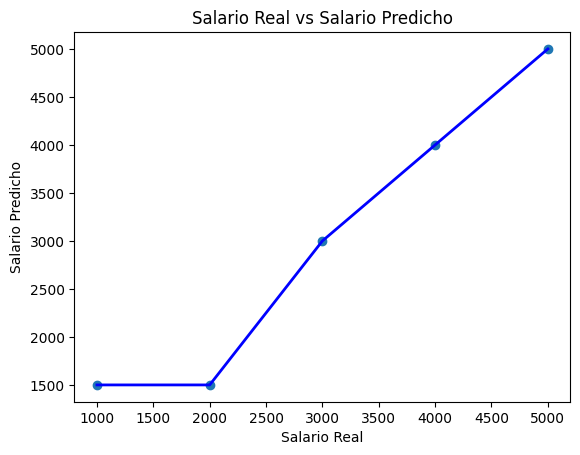

In [52]:
# X = data_dummy.drop(columns=['evaluacion'])
# y = data_dummy['salario']

X = data_dummy[
    ['departamento_RRHH', 'departamento_Finanzas', 'departamento_Tecnologia', 'departamento_Marketing']
]
y = data_dummy['salario']

model = LinearRegression()
model.fit(X, y)

predicciones = model.predict(X)

print('Coeficientes: ', model.coef_)
print('Intercepto: ', model.intercept_)

print('mse: ', mean_squared_error(y, predicciones))
print('R2: ', r2_score(y, predicciones))

plt.scatter(y, predicciones)
plt.plot(data['salario'], predicciones, color='blue', lw=2)
plt.xlabel('Salario Real')
plt.ylabel('Salario Predicho')
plt.title('Salario Real vs Salario Predicho')
plt.show()
